# Final Project

## Team Members
- Reham Abuarqoub, 9062922
- Erica Holden, 5490685
- Yu-Chen Chou (Tracy), 9006160 

## Tasks

* Clustering: Cluster launches by decade.
* Classification: Predict whether a mission will be successful or fail based on features like launch vehicle, country, payload, etc.
* Regression: Predict payload mass or cost based on mission details.
* Probabilistic Reasoning: Estimate the probability of mission success given country and vehicle type.

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [4]:
# Load dataset
df = pd.read_csv('./data/Space_Corrected.csv')

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

# Correcting spacing issue with column name
df["Rocket"] = df[" Rocket"]

# Display first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
  Company Name                                           Location  \
0       SpaceX         LC-39A, Kennedy Space Center, Florida, USA   
1         CASC  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2       SpaceX                      Pad A, Boca Chica, Texas, USA   
3    Roscosmos       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4          ULA           SLC-41, Cape Canaveral AFS, Florida, USA   

                        Datum                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Status Rocket  Rocket Status Mission  Rocket  
0  StatusActive   50.0         S

## Clustering by Decade

C:\Users\Erica\AppData\Local\Temp\ipykernel_8020\494499649.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.fillna(0)


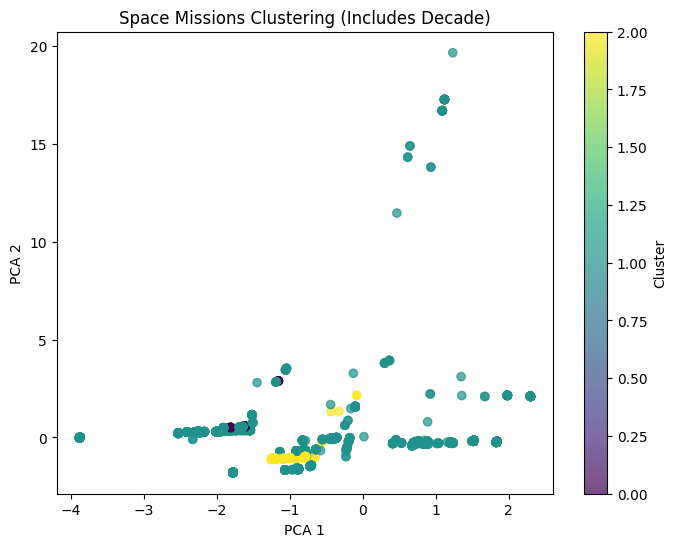

In [ ]:
# Extract the decade from the date year
df['Year'] = pd.to_datetime(df['Datum'], errors='coerce').dt.year
df['Decade'] = (df['Year'] // 10) * 10

df['Country'] = df['Location'].str.split(',').str[-1].str.strip()
df['Rocket_Family'] = df['Rocket'].str.extract(r'([A-Za-z]+(?:\s\d+)?)')
df['Rocket_Use_Count'] = df.groupby('Rocket')['Rocket'].transform('count')

# Select features for clustering
features = df[['Decade', 'Country', 'Rocket_Family', 'Company Name', 'Rocket_Use_Count']]
features = features.fillna(0)

# One-hot encode categorical features
features_encoded = pd.get_dummies(features)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_encoded)

# Cluster
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters by decade
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Space Missions Clustering (Includes Decade)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
# Print table of cluster counts by decade
decade_cluster_counts = df.groupby(['Decade', 'Cluster']).size().unstack(fill_value=0)
print(decade_cluster_counts)


Cluster   0    1    2
Decade               
1950.0    0   45    0
1960.0   13  739    0
1970.0   49  918   16
1980.0   29  563   15
1990.0   17  571   39
2000.0    0  411   53
2010.0    0  537  120
2020.0    0   41   22


## Summary of Clusters

| Cluster | Represents...       | Decades Active | Characteristics (Possible)      |
| ------- | ------------------- | -------------- | ------------------------------- |
| 0       | Early missions      | 1960s–1990s    | Legacy tech, early programs     |
| 1       | Standard/mainstream | 1950s–2020s    | Dominant, government-heavy      |
| 2       | Modern/emerging     | 1970s–2020s    | Private, innovative, newer tech |
